## Credit default model POPO
The purpose of this project is to create a model that is able to predict whether a loan will be defaulted based on a set of attributes of the individuals.

### Summary of results

### 0. Importing libraries and data, and general setup

#### Importing libraries and setting up the environment

In [113]:
# Importing libraries Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
# Keep graphs in line
%matplotlib inline
# Show all columns in pandas
pd.set_option('max_columns', None)
# Graphing style
plt.style.use('seaborn-colorblind')

#### Importing data from csv files

In [18]:
# Importing training data provided
df_train = pd.read_csv('data/train.csv')
# Converting all column names into lowercase and removing any spaces
df_train.columns = [x.strip().lower() for x in df_train.columns]
# Importing testing data
df_test = pd.read_csv('data/test.csv')
# Converting all column names into lowercase and removing any spaces
df_test.columns = [x.strip().lower() for x in df_test.columns]

### 1. Exploratory data analysis

#### Understanding data shapes
We are provided with the following two sets of data containing information about past costumers including their payment behavior. 
- A training dataset that will be used to train and calibrate the parameters of our model, containing 16,671 observations with 12 attributes and 1 target variable to predict.
- A testing dataset that will be used to test the model that we create with brand new observations and see the performance, including 4,168 observations and no target.

The data is consistent across samples in terms of the attributes we have available to model. Therefore, from this point on the analysis will be focused on the training dataset.

In [47]:
# Printing shapes of the datasets
# Training datset shape
print('Training dataset')
print('- Observations:', str(df_train.shape[0]))
print('- Attributes:', str(df_train.shape[1] - 1))
print('- Target:', str(1))
# Testing dataset
print('Testing dataset')
print('- Observations:', str(df_test.shape[0]))
print('- Attributes:', str(df_test.shape[1]))
# Verifying variables
#print('\n')
if list(df_train.columns[0:-1]) == list(df_test.columns): 
    print('Variables consistency: No issues')


Training dataset
- Observations: 16671
- Attributes: 12
- Targer: 1
Testing dataset
- Observations: 4168
- Attributes: 12
Variables consistency: No issues


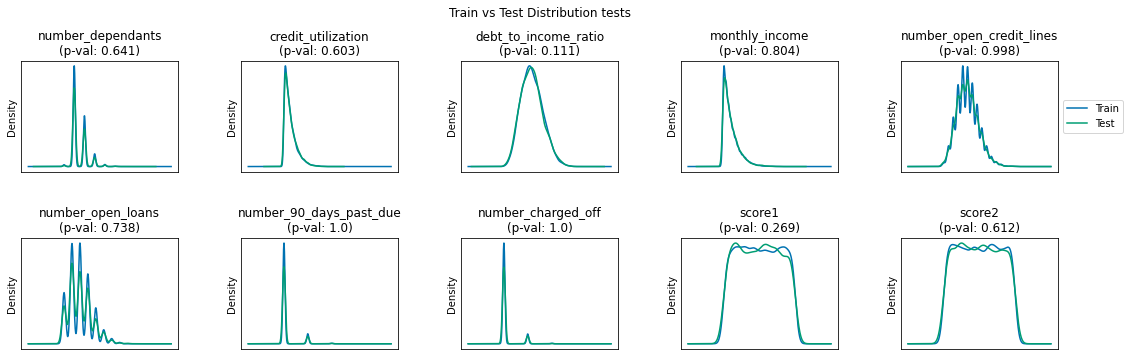

In [138]:
# Plot of the distribution of variables between training and testing
fig, ax = plt.subplots(2,5)                     # Create a 5x2 grid of subplots
fig.set_size_inches((18,5))
fig.suptitle('Train vs Test Distribution tests', y=1.05)
plt.subplots_adjust(left=0.1,                   # Adjust the space between the subplots
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 2
for row in range(2):                                                        # Rows loop
    for col in range(5):                                                    # Columns loop
        current_col = df_train.columns[col_index]                           # Curent column
        p_val = ks_2samp(df_train[current_col], df_test[current_col])[1]    # Kolmogorov-Smirnov test for goodness of fit (p-val)
        ax[row][col].set_title(current_col + '\n' + 
                             '(p-val: {})'.format(round(p_val, 3)))
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=False, right=False, labelleft=False, labelbottom=False)
        df_train[current_col].plot.kde(ax=ax[row][col])
        df_test[current_col].plot.kde(ax=ax[row][col])
        col_index += 1
    
ax[0][4].legend(['Train', 'Test'], loc='center left', bbox_to_anchor=(1, 0.5))

# Save image
plt.savefig('figures/train_vs_test_dist.png')


In [123]:
 ks_2samp(df_train['number_dependants'], df_test['number_dependants'])[1]

0.6407982566693968

<AxesSubplot:xlabel='number_dependants', ylabel='Density'>

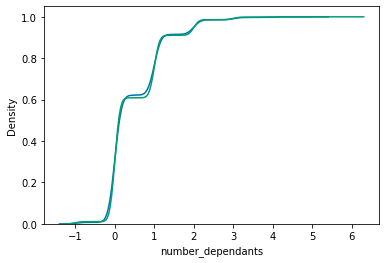

In [120]:
sns.kdeplot(data=df_test['number_dependants'], cumulative=True)
sns.kdeplot(data=df_train['number_dependants'], cumulative=True)

#### Understanding the data

From

In [23]:
# Descriptive statistics
df_train.describe().round(decimals=2)

,id,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target
count,16671.00,16671.00,16671.00,16671.00,16671.00,16671.00,16671.00,16671.00,16671.00,16671.00,16671.00,16671.0
mean,10917.57,0.49,0.05,0.33,2289.90,5.00,2.03,0.10,0.10,669.90,669.49,0.1
std,6309.00,0.72,0.05,0.12,319.47,2.25,1.43,0.32,0.32,98.01,98.61,0.3
min,1.00,-1.00,0.00,0.03,2000.00,0.00,0.00,0.00,0.00,500.00,500.00,0.0
25%,5474.50,0.00,0.01,0.25,2100.00,3.00,1.00,0.00,0.00,585.00,583.00,0.0
50%,10967.00,0.00,0.03,0.33,2200.00,5.00,2.00,0.00,0.00,669.00,670.00,0.0
75%,16349.00,1.00,0.07,0.41,2400.00,6.00,3.00,0.00,0.00,756.00,754.00,0.0
max,21839.00,6.00,0.54,0.80,5000.00,15.00,9.00,3.00,3.00,839.00,839.00,1.0


In [36]:
df_train.boxplot

16671

#### Exploring correlations between variables

In [6]:
df_train[0:5]

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target
0,1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0
1,2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0
2,3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0
3,5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0
4,6,1994-02-03,0,0.001003,0.251700,2500,6,6,0,1,830,587,0


<AxesSubplot:title={'center':'ROC Correlation heatmap'}>

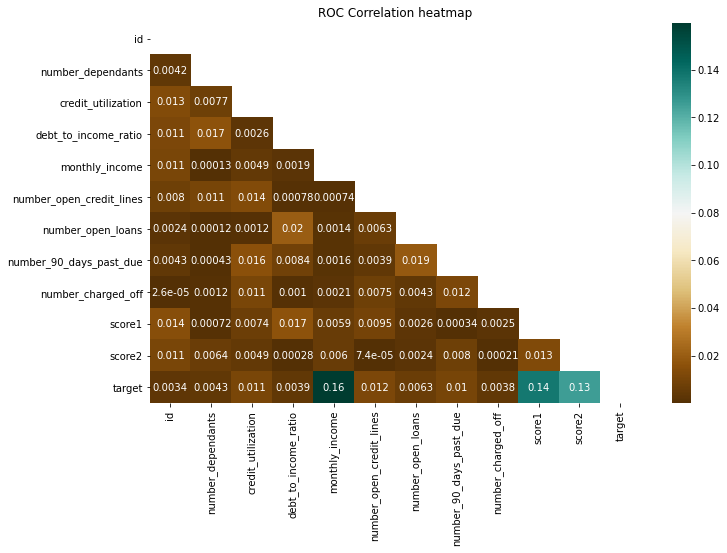

In [24]:
# Creating correlation matrix graph
plt.figure(figsize=(11,7))
plt.title('ROC Correlation heatmap')
# Mask that allows us to get only the diagonal values 
mask = np.triu(np.ones_like(df_train.drop('id').corr(), dtype=np.bool))
# Graphing correlation matrix
sns.heatmap(df_train.corr().abs(), annot=True, mask=mask, cmap='BrBG')